### Links 

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

### Loding Usefull Modules 

In [2]:
from __future__ import print_function
import torch
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from tqdm import tqdm
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import os 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import torch.onnx

In [4]:
torch.__version__

'1.3.1'

### Loading User_defined modules

In [5]:
import albumentations as A

In [6]:
import model_utility.data_utils as dutils
import model_utility.model_utils as mutils
import model_utility.plot_utils as putils 
import model_utility.regularization as regularization
import model_utility.alb_utils as alb
from model_utility.LR_finder import lr_test

In [7]:
import tsai_models.model_cifar as model_cifar
import tsai_models.models as mod

import albumentations as A
from albumentations.pytorch import ToTensor

import grad_cam.grad_cam_viz as grad_cam_viz

# Check GPU avaiability

In [8]:
device = dutils.get_device()

CUDA Available? True
Device is cuda:0


In [9]:
cuda = torch.cuda.is_available()
print(cuda)

True


# Downloading the dataset

In [10]:
import zipfile
import os
import requests
from io import StringIO, BytesIO

def download_dataset(url, zipfile_name):
    if (os.path.isdir(zipfile_name)):
        print ('Images already downloaded...')
        return
    r = requests.get(url, stream=True)
    print ('Downloading ' + url )
    zip_ref = zipfile.ZipFile(BytesIO(r.content))
    zip_ref.extractall('./')
    zip_ref.close()
    print('Downloading and extraction completed')

In [11]:
TINY_IMAGENET_URL = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
ZIP_FILENAME = "tiny-imagenet-200"
download_dataset(TINY_IMAGENET_URL,ZIP_FILENAME)

Images already downloaded...


In [12]:
!ls

EVA5_session_12.ipynb  model_utility  tiny-imagenet-200       tsai_models
grad_cam	       __pycache__    tiny-imagenet-200_eva
model_log	       readme.md      TinyImagenetDataset.py


## Tiny_Net Data Prep

In [13]:
ORIG_IMAGE_DIR = "./tiny-imagenet-200"
DEST_IMAGE_DIR = "./tiny-imagenet-200_eva"
TRAIN_IMAGE_DIR = os.path.join(DEST_IMAGE_DIR,"train")
VAL_IMAGE_DIR = os.path.join(DEST_IMAGE_DIR,"val")

In [14]:
from TinyImagenetDataset import TinyImagenetDataset

In [15]:
tiny_imagenet = TinyImagenetDataset(ORIG_IMAGE_DIR)

In [16]:
tiny_imagenet.create_imagefolder(DEST_IMAGE_DIR)

Dataset is already ready and existing..


In [17]:
classes = tuple(tiny_imagenet.class_name_list)
classes[:5]

('Egyptian cat', 'reel', 'volleyball', 'rocking chair', 'lemon')

In [18]:
means, stds = [0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]
print("means: {}".format(means))
print("stds: {}".format(stds))

means: [0.4802, 0.4481, 0.3975]
stds: [0.2302, 0.2265, 0.2262]


# Load dataset

In [19]:
path = os.getcwd()
path

'/home/abhinav/TSAI/working'

In [20]:
import albumentations as A

In [21]:
batch_size = 128

In [22]:
train_transforms, test_transforms = alb.get_data_transform('./')

In [23]:
config_params = dict(
    seed=1,
    batch_size=128,
    num_workers=4,
    epochs=50
)

In [24]:
train_loader, test_loader = alb.get_dataloader_img_folder(
                                            TRAIN_IMAGE_DIR, VAL_IMAGE_DIR,
                                            train_transforms, test_transforms, 
                                            batch_size=config_params["batch_size"], num_workers=config_params["num_workers"])

CUDA Available? True


# Data mage Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

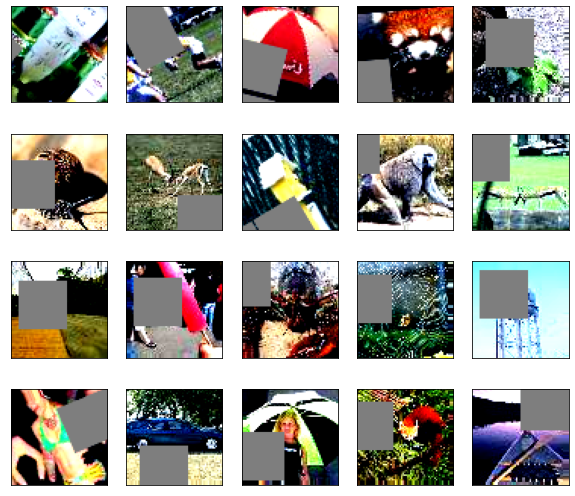

In [25]:
#Plot 20 random images
putils.plot_dataset_images(device, classes, train_loader,save_path ='model_log/images')

### Model stracture

In [26]:
model = mod.ResNet18_tin()

In [27]:
mutils.model_summary(model, device, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

In [28]:
# Create CIFAR10 network
# model = model_cifar.Net(dropout_value = 0.05)
# mutils.model_summary(model, device, input_size=(3, 32, 32))

In [29]:

from tqdm import tqdm

In [30]:
# !pip install torch_lr_finder
# import torch.optim as optim
# import torch.nn as nn
# from torch_lr_finder import LRFinder
# optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.95, nesterov=True)
# criterion = nn.CrossEntropyLoss()
# lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
# lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
# lr_finder.plot()
# loss = lr_finder.history['loss']
# lr = lr_finder.history['lr']
    
# lr = lr[loss.index(min(loss))]
# print('Using Learning Rate : ', lr)
# lr_finder.reset()

In [31]:
# import torch.nn as nn 
# max_lr = 2
# min_lr = 1.5

# print('Max LR :{} and MIN LR : {}'.format(max_lr,min_lr))
# epoch = 20



In [32]:
# lr_test(max_lr, min_lr,device,epoch,model,criterion,train_loader,momemtum = 0.9,weight_decay=0.0005, plot= True)

# Build and train model

In [33]:
# lr =0.625

In [ ]:
# build and train the model
model_name = "Tiny_image_net"
EPOCHS = 50
model =  model.to(device) # use GPU

# using L1 and L2 regularization
train_acc, train_losses, test_acc, test_losses = mutils.build_model(model, 
                                                            device, 
                                                            trainloader=train_loader, 
                                                            testloader=test_loader, 
                                                            epochs=EPOCHS,
                                                            L1_loss_flag=False,
                                                            L2_penalty_val=0.0005, lr = 0.1)

  0%|          | 0/602 [00:00<?, ?it/s]

EPOCH: 0


Loss=4.679756 Batch_id=601 Accuracy=5.86: 100%|██████████| 602/602 [03:44<00:00,  2.68it/s]

LR: [0.020086640079760718]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 4.342116, Accuracy: 3308/33000 (10.02%)

EPOCH: 1


Loss=3.950535 Batch_id=601 Accuracy=14.02: 100%|██████████| 602/602 [03:47<00:00,  2.65it/s]

LR: [0.04007328015952144]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 4.748775, Accuracy: 3087/33000 (9.35%)

EPOCH: 2


Loss=3.543906 Batch_id=601 Accuracy=20.13: 100%|██████████| 602/602 [03:48<00:00,  2.64it/s]

LR: [0.06005992023928216]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 3.986285, Accuracy: 5400/33000 (16.36%)

EPOCH: 3


Loss=3.275473 Batch_id=601 Accuracy=24.90: 100%|██████████| 602/602 [03:47<00:00,  2.64it/s]

LR: [0.08004656031904288]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 3.576768, Accuracy: 7114/33000 (21.56%)

EPOCH: 4


Loss=3.071552 Batch_id=601 Accuracy=28.57: 100%|██████████| 602/602 [03:48<00:00,  2.64it/s]

LR: [0.09999631229235881]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 3.554331, Accuracy: 7486/33000 (22.68%)

EPOCH: 5


Loss=2.914982 Batch_id=601 Accuracy=31.57: 100%|██████████| 602/602 [03:48<00:00,  2.63it/s]

LR: [0.09777631229235881]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.795895, Accuracy: 11128/33000 (33.72%)

EPOCH: 6


Loss=2.772680 Batch_id=601 Accuracy=34.37: 100%|██████████| 602/602 [03:49<00:00,  2.63it/s]

LR: [0.09555631229235881]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.944628, Accuracy: 10561/33000 (32.00%)

EPOCH: 7


Loss=2.658605 Batch_id=601 Accuracy=36.46: 100%|██████████| 602/602 [03:48<00:00,  2.64it/s]

LR: [0.09333631229235881]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.949543, Accuracy: 10672/33000 (32.34%)

EPOCH: 8


Loss=2.577926 Batch_id=601 Accuracy=38.29: 100%|██████████| 602/602 [03:48<00:00,  2.63it/s]

LR: [0.09111631229235881]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 3.199939, Accuracy: 9520/33000 (28.85%)

EPOCH: 9


Loss=2.507320 Batch_id=601 Accuracy=39.49: 100%|██████████| 602/602 [03:47<00:00,  2.65it/s]

LR: [0.08889631229235881]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.783703, Accuracy: 11975/33000 (36.29%)

EPOCH: 10


Loss=2.443662 Batch_id=601 Accuracy=41.02: 100%|██████████| 602/602 [03:46<00:00,  2.66it/s]

LR: [0.08667631229235881]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.589462, Accuracy: 12853/33000 (38.95%)

EPOCH: 11


Loss=2.384258 Batch_id=601 Accuracy=42.07: 100%|██████████| 602/602 [03:47<00:00,  2.65it/s]

LR: [0.08445631229235881]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.776294, Accuracy: 11553/33000 (35.01%)

EPOCH: 12


Loss=2.329148 Batch_id=601 Accuracy=43.45: 100%|██████████| 602/602 [03:46<00:00,  2.65it/s]

LR: [0.08223631229235881]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.887574, Accuracy: 11408/33000 (34.57%)

EPOCH: 13


Loss=2.285588 Batch_id=601 Accuracy=44.14: 100%|██████████| 602/602 [03:48<00:00,  2.63it/s]

LR: [0.08001631229235881]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.752712, Accuracy: 12112/33000 (36.70%)

EPOCH: 14


Loss=2.238987 Batch_id=601 Accuracy=45.25: 100%|██████████| 602/602 [03:48<00:00,  2.64it/s]

LR: [0.07779631229235881]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.524150, Accuracy: 13544/33000 (41.04%)

EPOCH: 15


Loss=2.193296 Batch_id=601 Accuracy=46.24: 100%|██████████| 602/602 [03:46<00:00,  2.66it/s]

LR: [0.07557631229235881]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.544132, Accuracy: 13354/33000 (40.47%)

EPOCH: 16


Loss=2.161500 Batch_id=601 Accuracy=46.88: 100%|██████████| 602/602 [03:46<00:00,  2.66it/s]

LR: [0.07335631229235881]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.383976, Accuracy: 14218/33000 (43.08%)

EPOCH: 17


Loss=2.125225 Batch_id=601 Accuracy=47.63: 100%|██████████| 602/602 [03:46<00:00,  2.66it/s]

LR: [0.07113631229235881]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.501025, Accuracy: 13966/33000 (42.32%)

EPOCH: 18


Loss=2.089429 Batch_id=601 Accuracy=48.48: 100%|██████████| 602/602 [03:46<00:00,  2.66it/s]

LR: [0.06891631229235881]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.415870, Accuracy: 14157/33000 (42.90%)

EPOCH: 19


Loss=2.058020 Batch_id=601 Accuracy=49.18: 100%|██████████| 602/602 [03:46<00:00,  2.66it/s]

LR: [0.06669631229235881]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.595959, Accuracy: 13440/33000 (40.73%)

EPOCH: 20


Loss=2.025726 Batch_id=601 Accuracy=49.84: 100%|██████████| 602/602 [03:46<00:00,  2.66it/s]

LR: [0.06447631229235881]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.354080, Accuracy: 14558/33000 (44.12%)

EPOCH: 21


Loss=1.999123 Batch_id=601 Accuracy=50.48: 100%|██████████| 602/602 [03:46<00:00,  2.66it/s]

LR: [0.062256312292358805]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.398169, Accuracy: 14357/33000 (43.51%)

EPOCH: 22


Loss=1.971424 Batch_id=601 Accuracy=51.07: 100%|██████████| 602/602 [03:52<00:00,  2.59it/s]

LR: [0.060036312292358805]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.284872, Accuracy: 14877/33000 (45.08%)

EPOCH: 23


Loss=1.940440 Batch_id=601 Accuracy=51.65: 100%|██████████| 602/602 [03:46<00:00,  2.66it/s]

LR: [0.05781631229235881]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.554314, Accuracy: 13631/33000 (41.31%)

EPOCH: 24


Loss=1.916645 Batch_id=601 Accuracy=52.39: 100%|██████████| 602/602 [03:46<00:00,  2.66it/s]

LR: [0.055596312292358806]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.329287, Accuracy: 14928/33000 (45.24%)

EPOCH: 25


Loss=1.880970 Batch_id=601 Accuracy=52.94: 100%|██████████| 602/602 [03:47<00:00,  2.64it/s]

LR: [0.05337631229235881]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.370618, Accuracy: 14534/33000 (44.04%)

EPOCH: 26


Loss=1.865604 Batch_id=601 Accuracy=53.47: 100%|██████████| 602/602 [03:47<00:00,  2.65it/s]

LR: [0.051156312292358806]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.260806, Accuracy: 15106/33000 (45.78%)

EPOCH: 27


Loss=1.823288 Batch_id=601 Accuracy=54.14: 100%|██████████| 602/602 [03:45<00:00,  2.67it/s]

LR: [0.048936312292358806]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.598033, Accuracy: 14018/33000 (42.48%)

EPOCH: 28


Loss=1.798428 Batch_id=601 Accuracy=54.79: 100%|██████████| 602/602 [03:45<00:00,  2.67it/s]

LR: [0.04671631229235881]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.316393, Accuracy: 15525/33000 (47.05%)

EPOCH: 29


Loss=1.765768 Batch_id=601 Accuracy=55.39: 100%|██████████| 602/602 [03:45<00:00,  2.66it/s]

LR: [0.044496312292358814]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.236995, Accuracy: 15688/33000 (47.54%)

EPOCH: 30


Loss=1.748357 Batch_id=601 Accuracy=55.92: 100%|██████████| 602/602 [03:46<00:00,  2.66it/s]

LR: [0.04227631229235881]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.226024, Accuracy: 15893/33000 (48.16%)

EPOCH: 31


Loss=1.714665 Batch_id=601 Accuracy=56.49: 100%|██████████| 602/602 [03:46<00:00,  2.66it/s]

LR: [0.04005631229235881]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.241201, Accuracy: 15991/33000 (48.46%)

EPOCH: 32


Loss=1.684594 Batch_id=601 Accuracy=57.46: 100%|██████████| 602/602 [03:45<00:00,  2.67it/s]

LR: [0.0378363122923588]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.267083, Accuracy: 15438/33000 (46.78%)

EPOCH: 33


Loss=1.632833 Batch_id=601 Accuracy=58.32: 100%|██████████| 602/602 [03:46<00:00,  2.66it/s]

LR: [0.035616312292358815]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.306148, Accuracy: 15495/33000 (46.95%)

EPOCH: 34


Loss=1.610036 Batch_id=601 Accuracy=58.95: 100%|██████████| 602/602 [03:48<00:00,  2.63it/s]

LR: [0.0333963122923588]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.157099, Accuracy: 16225/33000 (49.17%)

EPOCH: 35


Loss=1.573082 Batch_id=601 Accuracy=59.92: 100%|██████████| 602/602 [03:51<00:00,  2.60it/s]

LR: [0.0311763122923588]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.097304, Accuracy: 16719/33000 (50.66%)

EPOCH: 36


Loss=1.534183 Batch_id=601 Accuracy=60.70: 100%|██████████| 602/602 [03:46<00:00,  2.65it/s]

LR: [0.028956312292358816]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.181751, Accuracy: 16371/33000 (49.61%)

EPOCH: 37


Loss=1.485838 Batch_id=601 Accuracy=61.66: 100%|██████████| 602/602 [03:53<00:00,  2.57it/s]

LR: [0.026736312292358816]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.135048, Accuracy: 16760/33000 (50.79%)

EPOCH: 38


Loss=1.442663 Batch_id=601 Accuracy=62.66: 100%|██████████| 602/602 [03:46<00:00,  2.66it/s]

LR: [0.024516312292358802]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.081780, Accuracy: 16764/33000 (50.80%)

EPOCH: 39


Loss=1.398024 Batch_id=601 Accuracy=63.99: 100%|██████████| 602/602 [03:46<00:00,  2.66it/s]

LR: [0.022296312292358803]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.183603, Accuracy: 16495/33000 (49.98%)

EPOCH: 40


Loss=1.340937 Batch_id=601 Accuracy=65.19: 100%|██████████| 602/602 [03:46<00:00,  2.66it/s]

LR: [0.020076312292358817]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.032953, Accuracy: 17415/33000 (52.77%)

EPOCH: 41


Loss=1.267538 Batch_id=601 Accuracy=67.08: 100%|██████████| 602/602 [03:46<00:00,  2.66it/s]

LR: [0.017856312292358803]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.000411, Accuracy: 17610/33000 (53.36%)

EPOCH: 42


Loss=1.201346 Batch_id=601 Accuracy=68.67: 100%|██████████| 602/602 [03:46<00:00,  2.66it/s]

LR: [0.015636312292358803]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.936937, Accuracy: 18138/33000 (54.96%)

EPOCH: 43


Loss=1.126401 Batch_id=601 Accuracy=70.55: 100%|██████████| 602/602 [03:46<00:00,  2.66it/s]

LR: [0.013416312292358817]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.924122, Accuracy: 18357/33000 (55.63%)

EPOCH: 44


Loss=1.027929 Batch_id=601 Accuracy=73.07: 100%|██████████| 602/602 [03:46<00:00,  2.65it/s]

LR: [0.011196312292358804]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.882253, Accuracy: 18504/33000 (56.07%)

EPOCH: 45


Loss=0.922872 Batch_id=601 Accuracy=75.74: 100%|██████████| 602/602 [03:45<00:00,  2.66it/s]

LR: [0.008976312292358804]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.873171, Accuracy: 18804/33000 (56.98%)

EPOCH: 46


Loss=0.811828 Batch_id=601 Accuracy=79.14: 100%|██████████| 602/602 [03:46<00:00,  2.66it/s]

LR: [0.006756312292358804]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.771308, Accuracy: 19447/33000 (58.93%)

EPOCH: 47


Loss=0.669260 Batch_id=601 Accuracy=83.09: 100%|██████████| 602/602 [03:46<00:00,  2.66it/s]

LR: [0.0045363122923588045]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.697876, Accuracy: 19953/33000 (60.46%)

EPOCH: 48


Loss=0.549531 Batch_id=601 Accuracy=86.59: 100%|██████████| 602/602 [03:46<00:00,  2.66it/s]

LR: [0.0023163122923588048]



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.642095, Accuracy: 20283/33000 (61.46%)

EPOCH: 49


Loss=0.442337 Batch_id=601 Accuracy=89.73: 100%|██████████| 602/602 [03:46<00:00,  2.66it/s]

LR: [9.631229235880501e-05]


# Test Accuracy

In [ ]:
mutils.get_test_accuracy(model, device, test_loader)

### Class level Accuracy

In [ ]:
mutils.class_based_accuracy(model, device, classes, test_loader)

# Visualization

In [ ]:
print("\nPloting Accuracy and Loss history: {}\n".format(model_name))
putils.plot_model_history(model_name, 
                   train_acc,test_acc,
                   train_losses,test_losses,
                   save_filename = "model_history",path = 'model_log/images')

# Misclassified images

In [ ]:
print ("\nPloting misclassified images: {}\n".format(model_name))

putils.miss_classification(model, 
                        device, 
                        classes,
                        testloader=test_loader,
                        path = 'model_log/images',
                        typ_of_file = 'test',
                        num_of_images = 20,
                        save_filename="model_misclassified")

In [ ]:
import gradcam.gradcam_abs as gradcamAbs1 

In [ ]:
means,stds = alb.find_stats('model_log/cifar_10_data/')

In [ ]:
config = dict(model_type='resnet', arch=model, layer_name='layer4')
gcam = gradcamAbs1.GradCamAbs(device, config, means, stds)

In [ ]:
gradcam_images, pred_results = gcam.applyOnMisclassifiedImages(dataloader=test_loader, num_of_images=25)

In [ ]:
gcam.plot_results(gradcam_images, pred_results, classes, save_filename="gradcam_result_details")

In [ ]:
import matplotlib.pyplot as plt
from drishtypy.learner import learner
epochs = []
for i in range(24):
  epochs.append(i+1)

plt.plot(epochs,learner.LR)
plt.ylabel('Learning rate')
plt.xlabel("epoch")
plt.title("Lr v/s epochs")
plt.show()